# What does a neural network learn?

### Setting up

**Notebook setup**. Select the "Edit" menu, then "Notebook settings". Choose "GPU" as the hardware accelerator. Check that "Omit code cell output..." is unchecked (so that the output is saved).

**Upload dataset** Select the folder icon from the left sidebar menu. Click the upload button and select the file "lab6data.zip" from your computer.

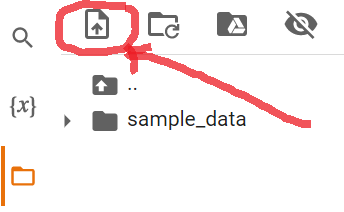

### Extract the dataset

In [1]:
!unzip lab6data.zip

Archive:  lab6data.zip
   creating: lab6/
   creating: lab6/test/
   creating: lab6/test/Cat/
  inflating: lab6/test/Cat/10045.jpg  
  inflating: lab6/test/Cat/10076.jpg  
  inflating: lab6/test/Cat/10150.jpg  
  inflating: lab6/test/Cat/10310.jpg  
  inflating: lab6/test/Cat/10347.jpg  
  inflating: lab6/test/Cat/10671.jpg  
  inflating: lab6/test/Cat/10691.jpg  
  inflating: lab6/test/Cat/10877.jpg  
  inflating: lab6/test/Cat/10895.jpg  
  inflating: lab6/test/Cat/1117.jpg  
  inflating: lab6/test/Cat/11281.jpg  
  inflating: lab6/test/Cat/11397.jpg  
  inflating: lab6/test/Cat/11412.jpg  
  inflating: lab6/test/Cat/11427.jpg  
  inflating: lab6/test/Cat/11515.jpg  
  inflating: lab6/test/Cat/11517.jpg  
  inflating: lab6/test/Cat/11559.jpg  
  inflating: lab6/test/Cat/11583.jpg  
  inflating: lab6/test/Cat/11610.jpg  
  inflating: lab6/test/Cat/11713.jpg  
  inflating: lab6/test/Cat/12165.jpg  
  inflating: lab6/test/Cat/12210.jpg  
  inflating: lab6/test/Cat/12268.jpg  
  inflatin

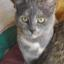

In [2]:
from PIL import Image
im = Image.open("lab6/train/Cat/161.jpg")
display(im)

### Import PyTorch

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

### Prepare the dataset for PyTorch


In [8]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [9]:
train_ds = datasets.ImageFolder('lab6/train', transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [10]:
test_ds = datasets.ImageFolder('lab6/test', transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [19]:
print(f'Number of classes: {len(train_ds.classes)}')
print(f'Class names: {train_ds.classes}')
print(f'Number of images: {len(train_ds)}')
print(f'Number of images: {len(test_ds)}')

Number of classes: 2
Class names: ['Cat', 'Dog']
Number of images: 1800
Number of images: 200


### Experiment 1: train a model from scratch

Follow the instructions in moodle. You can start adding code in cells below and running them by pressing the forward arrow button in the corner. Add more cells as needed.

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.cnn_stack(x)


In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
model = CNN().to(device)

Using cuda device


In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
# @title
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [26]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.694167  [   32/ 1800]
loss: 0.680337  [  352/ 1800]
loss: 0.691250  [  672/ 1800]
loss: 0.696001  [  992/ 1800]
loss: 0.715411  [ 1312/ 1800]
loss: 0.683613  [ 1632/ 1800]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.728576 

Epoch 2
-------------------------------
loss: 0.736709  [   32/ 1800]
loss: 0.659186  [  352/ 1800]
loss: 0.682993  [  672/ 1800]
loss: 0.695326  [  992/ 1800]
loss: 0.689196  [ 1312/ 1800]
loss: 0.744323  [ 1632/ 1800]
Test Error: 
 Accuracy: 53.5%, Avg loss: 0.686128 

Epoch 3
-------------------------------
loss: 0.660831  [   32/ 1800]
loss: 0.665596  [  352/ 1800]
loss: 0.637089  [  672/ 1800]
loss: 0.632575  [  992/ 1800]
loss: 0.590826  [ 1312/ 1800]
loss: 0.677529  [ 1632/ 1800]
Test Error: 
 Accuracy: 54.0%, Avg loss: 0.679472 

Epoch 4
-------------------------------
loss: 0.655850  [   32/ 1800]
loss: 0.710298  [  352/ 1800]
loss: 0.711641  [  672/ 1800]
loss: 0.717297  [  992/ 1800]
loss: 0.658574  [ 1312/ 

Q1: What was the result (average accuracy of classifying cats and dogs in experiment 1)? Explain or comment the result. [The model achieved an average test accuracy of approximately 67.0% by the end of training after 15 epochs]

### Experiment 2: side channel data

In [27]:
!mkdir -p lab6/train2/Cat lab6/train2/Dog lab6/test2/Cat lab6/test2/Dog

In [28]:
import os
import os.path

RED_TINT = [1.1, 0, 0, 0,
           0, 1, 0, 0,
           0, 0, 0.9, 0]
BLUE_TINT = [0.9, 0, 0, 0,
           0, 1, 0, 0,
           0, 0, 1.1, 0]
def tone_images(ipath, opath, matrix):
    files = os.listdir(ipath)
    for fn in files:
        src = os.path.join(ipath, os.path.basename(fn))
        dest = os.path.join(opath, os.path.basename(fn))
        im = Image.open(src)
        im.convert("RGB", matrix).save(dest)

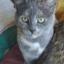

In [29]:
tone_images("lab6/train/Cat", "lab6/train2/Cat", BLUE_TINT)
tone_images("lab6/train/Dog", "lab6/train2/Dog", RED_TINT)
tone_images("lab6/test/Cat", "lab6/test2/Cat", BLUE_TINT)
tone_images("lab6/test/Dog", "lab6/test2/Dog", RED_TINT)

im = Image.open("lab6/train2/Cat/161.jpg")
display(im)

In [30]:
train_ds2 = datasets.ImageFolder('lab6/train2', transform=transform)
test_ds2 = datasets.ImageFolder('lab6/test2', transform=transform)

train_dataloader2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_ds2, batch_size=batch_size, shuffle=False)

In [31]:
model2 = CNN().to(device)
optimizer2 = optim.Adam(model2.parameters())
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader2, model2, loss_fn, optimizer2)
    test(test_dataloader2, model2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.713164  [   32/ 1800]
loss: 0.541630  [  352/ 1800]
loss: 0.386459  [  672/ 1800]
loss: 0.278888  [  992/ 1800]
loss: 0.265736  [ 1312/ 1800]
loss: 0.180327  [ 1632/ 1800]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.290905 

Epoch 2
-------------------------------
loss: 0.191985  [   32/ 1800]
loss: 0.099508  [  352/ 1800]
loss: 0.233071  [  672/ 1800]
loss: 0.292476  [  992/ 1800]
loss: 0.154661  [ 1312/ 1800]
loss: 0.276031  [ 1632/ 1800]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.305124 

Epoch 3
-------------------------------
loss: 0.376044  [   32/ 1800]
loss: 0.294571  [  352/ 1800]
loss: 0.302335  [  672/ 1800]
loss: 0.333810  [  992/ 1800]
loss: 0.245344  [ 1312/ 1800]
loss: 0.225885  [ 1632/ 1800]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.271099 

Epoch 4
-------------------------------
loss: 0.173217  [   32/ 1800]
loss: 0.259537  [  352/ 1800]
loss: 0.204143  [  672/ 1800]
loss: 0.296999  [  992/ 1800]
loss: 0.059092  [ 1312/ 

Q2: What was the result after altering the color balance of images? Explain or comment the result. [After altering the color balance of images (cooler tones for cats and warmer tones for dogs), the model achieved a significantly higher test accuracy of ~89.5–93.5% compared to Experiment 1. The average test loss also decreased, indicating improved confidence in predictions.]

### Experiment 3: adversarial data

In [34]:
!mkdir -p lab6/test3/Cat lab6/test3/Dog

In [35]:
tone_images("lab6/test/Cat", "lab6/test3/Cat", RED_TINT)
tone_images("lab6/test/Dog", "lab6/test3/Dog", BLUE_TINT)

In [36]:
test_ds3 = datasets.ImageFolder('lab6/test3', transform=transform)
test_dataloader3 = DataLoader(test_ds3, batch_size=batch_size, shuffle=False)

In [37]:
test(test_dataloader3, model2, loss_fn)

Test Error: 
 Accuracy: 11.5%, Avg loss: 10.440169 



Q3: What was the result after using a different color alteration in test images? Explain or comment the result.[After altering the test images to swap the color tones, the model's accuracy dropped drastically to 11.5%, with a very high average loss of 10.440169. This is significantly worse than random guessing (50% for two classes).]

### Experiment 4: transfer learning

In [38]:
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in base_model.parameters():
    param.requires_grad = False

class PretrainedModel(nn.Module):
    def __init__(self, base_model):
        super(PretrainedModel, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_model.fc.in_features, 2)

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model4 = PretrainedModel(base_model).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


In [40]:
transform4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds4 = datasets.ImageFolder('lab6/train2', transform=transform4)
test_ds4 = datasets.ImageFolder('lab6/test3', transform=transform4)

train_dataloader4 = DataLoader(train_ds4, batch_size=batch_size, shuffle=True)
test_dataloader4 = DataLoader(test_ds4, batch_size=batch_size, shuffle=False)




In [41]:
optimizer4 = optim.Adam(model4.parameters())

In [42]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader4, model4, loss_fn, optimizer4)
    print("\n")
print("Done!")

Epoch 1
-------------------------------
loss: 0.651123  [   32/ 1800]
loss: 0.488797  [  352/ 1800]
loss: 0.380000  [  672/ 1800]
loss: 0.404151  [  992/ 1800]
loss: 0.229642  [ 1312/ 1800]
loss: 0.204450  [ 1632/ 1800]


Epoch 2
-------------------------------
loss: 0.138775  [   32/ 1800]
loss: 0.169438  [  352/ 1800]
loss: 0.156175  [  672/ 1800]
loss: 0.082593  [  992/ 1800]
loss: 0.110982  [ 1312/ 1800]
loss: 0.112437  [ 1632/ 1800]


Epoch 3
-------------------------------
loss: 0.054376  [   32/ 1800]
loss: 0.088560  [  352/ 1800]
loss: 0.149155  [  672/ 1800]
loss: 0.119701  [  992/ 1800]
loss: 0.071924  [ 1312/ 1800]
loss: 0.186265  [ 1632/ 1800]


Epoch 4
-------------------------------
loss: 0.068845  [   32/ 1800]
loss: 0.268620  [  352/ 1800]
loss: 0.153561  [  672/ 1800]
loss: 0.224266  [  992/ 1800]
loss: 0.126110  [ 1312/ 1800]
loss: 0.032319  [ 1632/ 1800]


Epoch 5
-------------------------------
loss: 0.045267  [   32/ 1800]
loss: 0.069459  [  352/ 1800]
loss: 0.1960

Q4: The ResNet50 based model was trained and tested just like in experiment 3. What happened? Explain or comment the result. [The ResNet50 model performed well because it was pretrained on the large and diverse ImageNet dataset, enabling it to learn robust, generalizable features like edges and shapes. Unlike the CNN in Experiment 3, which relied on color biases, ResNet50's feature extraction was unaffected by adversarial color alterations. By fine-tuning only the classifier layer, it adapted to the task while retaining its strong, pre-learned generalization abilities, making it resilient to dataset-specific biases.]